# Aggregating Inputs for Capstone Project

- Begin by cleaning symbols
- Using the `pandas_datareader` to fetch historical prices for:
    - Tickers 
    - ETF's
- Save results to a new csv file 

***

## Gathering data for capstone project. Initial thoughts:

- 10-15yrs of historical asset pricing (create custom ticker list)
- ETF prices for style exposures (iShares Large Cap, etc.)
- Fama & French 
- Use TA-Lib for technical factors

Helpful links:

- https://towardsdatascience.com/python-for-finance-stock-portfolio-analyses-6da4c3e61054
- https://github.com/robertmartin8/MachineLearningStocks#historical-stock-fundamentals

# Machine Learning Engineer Nanodegree

## Capstone Project

**Joe Importico** 
**February 22, 2019**
***

## Forecasting the Cross-section of Asset Returns

In this notebook, we will generate our dataset, identify and treat outliers, engineer features, and analyze the predictive power of price based momentum factors when it comes to forecasting the cross-section of asset returns. To begin that process, we are going to collect our inputs from a variety of sources. Time-series asset prices will be collected using the `pandas_datareader`, as will historical ETF prices. In addition to asset and ETF prices, we are also going to query return streams for the [Fama & French](http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html) style indices.

The primary areas of our analysis will cover the following sections:

- Collecting Data
- Post Processing 
- Feature Engineering
- Machine Learning

The links above can be used to navigate to the various components of this analysis.

In [2]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

import pandas_datareader as pdr
import fix_yahoo_finance as yf

## Collecting Data

We begin by importing the `assets.csv` file containing baseline information and the symbols we will use to query historical prices.

In [2]:
#Load asset data and reformat
secs = pd.read_csv('data//assets.csv')

#Reformat dates to Datetime format & drop uneccessary columns
secs['dates'] = pd.DatetimeIndex(secs['Periods'])
cols_to_drop = ['Unnamed: 0', 
                'Periods', 
                'Weight', 
                'Market Capitalization', 
                'country (Fractiles)', 
                'mval (Fractiles)']
secs.drop(cols_to_drop, axis=1, inplace=True)

#String formatting to query different share classees. Yahoo
#expects ticker-share class
secs['hist_ticker'] = secs['ticker_exchange'].str.split('-')\
.str[0].str.replace('.','-')

#Rename columns
secs.columns = ['name', 
                'ticker_nonpit', 
                'rets_1m', 
                'rets_3m', 
                'country', 
                'mval', 
                'cusip', 
                'ticker_region', 
                'ticker_exchange', 
                'fsym', 
                'dates', 
                'hist_ticker']

#Set index, sort, and preview
secs.set_index(['dates', 'hist_ticker'], inplace=True)
secs.sort_index(inplace=True)
secs.head()

name ticker_nonpit  \
dates      hist_ticker                                                  
2003-12-31 A                 Agilent Technologies, Inc.          A-US   
           AA                               Alcoa Corp.         AA-US   
           AAP                 Advance Auto Parts, Inc.        AAP-US   
           ABC            AmerisourceBergen Corporation        ABC-US   
           ABI          Applera Corp-Applied Biosystems    ABI.XX1-US   

                        rets_1m  rets_3m        country      mval      cusip  \
dates      hist_ticker                                                         
2003-12-31 A              26.06     8.17  UNITED STATES  11865.64  00846U101   
           AA            -10.05    -8.32  UNITED STATES  27319.26  013817101   
           AAP            -4.37    -0.07  UNITED STATES   2886.79  00751Y106   
           ABC            -1.96    -2.57  UNITED STATES   6358.37  03073E105   
           ABI            14.15    -4.29  UNITED STATES   4801.26  038020103   

                       ticker_region ticker_exchange      fsym  
dates      hist_ticker                                          
2003-12-31 A                    A-US           A-USA  FWHC5K-R  
           AA                  AA-US          AA-USA  B8374S-R  
           AAP                AAP-US         AAP-USA  HP58X9-R  
           ABC                ABC-US         ABC-USA  BK2FRW-R  
           ABI                ABI-US         ABI-USA  VNRHTY-R

Upsample the frequency of the data from monthly to daily and set the calendar to follow the `USFederalHolidayCalendar`. This will be helpful later on when we join pricing data back to this DataFrame. 

In [4]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

secs_df = secs.pivot_table(index='dates', 
                           columns='hist_ticker', 
                           values='mval')

#Set custom US Federal Holiday calendar
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

#Create new daily date range
start_date = secs_df.index.min()
end_date = secs_df.index.max()
dates = pd.bdate_range(start_date, 
                       end_date, 
                       freq=us_bd)

secs_df = pd.DataFrame(secs_df.reindex(dates, 
                                       method='ffill').stack('hist_ticker'),
                       columns=['mval'])

`asset_ids` represents the unique assets that will be used when querying historical asset prices from Yahoo Finance.

In [15]:
asset_ids = secs_df.index.get_level_values(1).unique().tolist()
print('Number of unique securities: {:,}'.format(len(asset_ids)))

Number of unique securities: 1,939


***
## DO NOT EXECUTE THE FOUR CELLS BELOW

The cells below will collect asset and ETF prices. These are lengthy queries, so to save time, the results have been written to two files which can be imported directly.
 
The link below can be used to skip ahead to import the `input_df` which has been generated by the cell below.

### [Skip Forward to Data Import](#step0)

### Query for historical asset prices 

In [31]:
#Track progress 
from tqdm import tqdm

start_date = '2005-12-30'
end_date = '2018-12-31'
dropped_tickers =[]
pricing_data = {}
for ticker in tqdm(asset_ids):
    try:
        pricing_data[ticker] = pdr.data.get_data_yahoo(ticker, 
                                                       start_date, 
                                                       end_date)
    except:
        dropped_tickers.append(ticker)
        
#join data & swap index levels
input_df = pd.concat(pricing_data)

input_df = input_df.swaplevel(0)  #swap levels
input_df.sort_index(level=0, inplace=True)

100%|██████████████████████████████████████████████████████████████████████████████| 2009/2009 [29:06<00:00,  1.26it/s]


In [32]:
#write to csv
input_df.to_csv('data//input_data.csv')

### Query for historical ETF prices

Gather ETF prices for each sector -- **note that real estate (XLRE) & communication services (XLC) will be ommitted for this exercise due to their limited history**

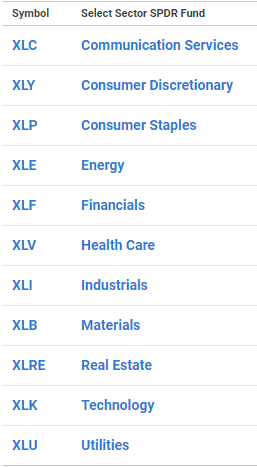


Source: https://www.sectorspdr.com/sectorspdr/sectors

In [16]:
#Define inputs
etf_ids = ['XLY', 'XLP', 'XLE', 'XLF', 'XLV', 'XLI', 'XLB', 'XLK', 'XLU']
start_date = '2005-12-30'
end_date = '2018-12-31'

dropped_etf =[]
etf_pricing = {}
for etf in tqdm(etf_ids):
    try:
        etf_pricing[etf] = pdr.data.get_data_yahoo(etf, start_date, end_date)
    except:
        dropped_etf.append(etf)
        
#join data & swap index levels
etf_prices = pd.concat(etf_pricing)

etf_prices = etf_prices.swaplevel(0)  #swap levels
etf_prices.sort_index(level=0, inplace=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.11s/it]


In [ ]:
#write to csv
etf_prices.to_csv('data//etf_prices.csv')

***

<a id='step0'></a>
## Import Data:
    
   - Asset Prices
   - ETF Prices
   - Fama & French Factors

In [84]:
#Import historical asset prices
input_df = pd.read_csv('data//input_data.csv')

#Change dates to datetime
input_df['Date'] = pd.to_datetime(input_df['Date'])

#Rename columns
input_df.columns = ['date', 
                    'ticker', 
                    'high', 
                    'low', 
                    'open', 
                    'close', 
                    'volume', 
                    'adj_close']

input_df.set_index(['date', 'ticker'], inplace=True)

#change ticker index to string
input_df.set_index([input_df.index.get_level_values(0), 
                    input_df.index.get_level_values(1).astype(str)], 
                   inplace=True)

Merge earlier DataFrame (secs) with input_df to capture market values for groups

In [85]:
secs_df.index.names = ['date', 'ticker']

#change ticker index to string
secs_df.set_index([secs_df.index.get_level_values(0), 
                   secs_df.index.get_level_values(1).astype(str)], 
                  inplace=True)

prices_df = pd.merge(secs_df[['mval']],
                     input_df, 
                     how='left', 
                     left_index=True, 
                     right_index=True)

#Exclude companies with a closing price less than $5 per share
prices_df = prices_df[prices_df['adj_close'] > 5.0]

#Use adjusted close values to compute daily returns
prices_df['daily_ret'] = prices_df.pivot_table(values='adj_close',
                                               index='date', 
                                               columns='ticker').pct_change(periods=1).stack()

Create market cap bins to divide securities into large-cap, mid-cap, and small-cap

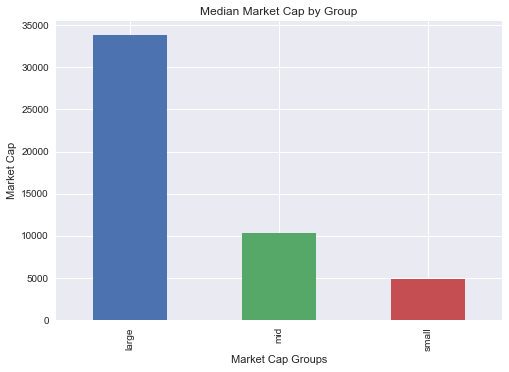

In [86]:
prices_df['mval_rank'] = prices_df.groupby(level=0)['mval'].rank(ascending=False)

prices_df['mcap_groups'] = prices_df['mval_rank'].groupby(level=0)\
    .apply(lambda x: pd.qcut(x=x, q=3, labels=['large', 'mid', 'small']))

#Display median market cap by group
prices_df.groupby('mcap_groups')['mval'].median().plot(kind='bar', 
                                                     title='Median Market Cap by Group')
plt.ylabel('Market Cap')
plt.xlabel('Market Cap Groups')
plt.show()

## Import ETF Prices

In [87]:
#Import historical ETF prices
etf_prices = pd.read_csv('data//etf_prices.csv', 
                         index_col=['Date', 'Unnamed: 1'])

etf_prices.index.names = ['date', 'symbol']

etf_prices.columns = ['high', 
                      'low', 
                      'open', 
                      'close', 
                      'volume', 
                      'adj_close']

#compute daily returns for ETF's
etf_prices['daily_ret'] = etf_prices['adj_close'].unstack().pct_change(periods=1).stack()

etf_prices.head()

high        low       open      close      volume  \
date       symbol                                                           
2005-12-30 XLB     30.420000  30.250000  30.420000  30.280001    718200.0   
           XLE     50.700001  49.639999  49.799999  50.310001  12112800.0   
           XLF     25.832657  25.653940  25.727051  25.727051   6315300.0   
           XLI     31.520000  31.389999  31.400000  31.420000    806400.0   
           XLK     20.990000  20.870001  20.990000  20.900000   1029900.0   

                   adj_close  daily_ret  
date       symbol                        
2005-12-30 XLB     22.524197        NaN  
           XLE     38.575603        NaN  
           XLF     14.961567        NaN  
           XLI     24.027067        NaN  
           XLK     17.223452        NaN

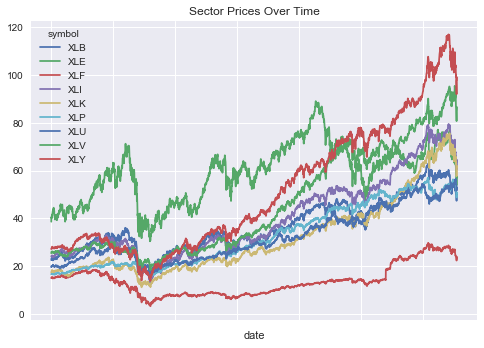

In [88]:
etf_prices['adj_close'].unstack(level=1).plot(title='Sector Prices Over Time');

## Import Fama & French Factor Returns

Details: http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/f-f_5developed.html

Good references:

- https://www.quantconnect.com/tutorials/introduction-to-financial-python/fama-french-multi-factor-models
- http://www.quantsportal.com/fama-french-five-factor-asset-pricing-model/


In [89]:
ff_rets = pd.read_csv('data//famafrenchformatted.csv')

ff_rets.columns = ['date', 
                   'mkt-rf', 
                   'smb', 
                   'hml', 
                   'rmw', 
                   'cma', 
                   'rf']

#format dates as datetime
ff_rets['date'] = pd.to_datetime(ff_rets['date'].astype(str))

#set dates to index
ff_rets.set_index('date', inplace=True)

#preview data
ff_rets.head()

,mkt-rf,smb,hml,rmw,cma,rf
date,,,,,,
2005-12-30,-0.42,-0.02,0.29,0.03,0.12,0.01
2006-01-02,-0.03,-0.01,-0.01,0.00,0.00,0.02
2006-01-03,1.59,-0.24,0.16,0.17,-0.26,0.02
2006-01-04,0.52,0.36,-0.14,-0.19,0.09,0.02
2006-01-05,-0.08,0.09,-0.21,-0.50,0.14,0.02


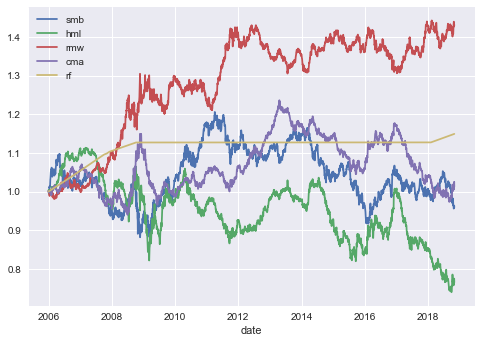

In [90]:
#Display cumulative factor returns
(ff_rets[['smb', 'hml', 'rmw', 'cma', 'rf']]/100+1).cumprod().plot();

***
# Feature Engineering

***

**IMPORTANT NOTE:** The computations in this section can be fairly computationally expensive, and as a result may take a while to run. You can skip forward to the Exploratory Data Analysis section. The information from this segment of the notebook has been written to a file and loaded in that section. The link below can be used to jump forward.

### [Skip Forward to Exploratory Data Analysis](#step1)
***


We will rely on our domain knowledge to engineer a diverse set of features using the OHLCV obtained earlier. OHLCV information is a great resource for conducting empirical research in the public domain. As we've seen up to this point, it's farily easy to acquire (though there are plenty of caveats which go beyond the scope of this assignment) and it lends itself to computing a rich feature space.

The features we will compute from here on out can be broadly categorized into one of two categories:

    1) Time-Series Exposures
    2) Technical Indicators

Time-series exposures are commonly used to approximate an assets' behavior with respect to another attribute when information on that attribute is unavailable. For example, we do not have access to an industry standard taxonomy, like [GICS](https://en.wikipedia.org/wiki/Global_Industry_Classification_Standard), but that doesn't mean we can't include that information in our study. Instead, we will approximate our assets' exposure to those groups by computing a coefficient based off of the underlying return streams of the assets and the groups. Assets with larger group coefficients experience similarities with respect to the behavior of their prices. A similar approach will be used to approximate style exposures too. This will help identify which assets behave like small or large cap, value or growth, etc.

Below are the features that will be computed throughout this section.

    • Time-Series Exposures:
        o Sectors:
            ▪ Beta to Communication Services (XLC)
            ▪ Beta to Consumer Discretionary (XLY)
            ▪ Beta to Consumer Staples (XLP)
            ▪ Beta to Energy (XLE)
            ▪ Beta to Financials (XLF)
            ▪ Beta to Health Care (XLV)
            ▪ Beta to Industrials (XLI)
            ▪ Beta to Materials (XLB)
            ▪ Beta to Technology (XLK)
            ▪ Beta to Utilities (XLU)
        o Styles:
            ▪ Beta to Fama & French SMB (Small Minus Big) portfolios
            ▪ Beta to Fama & French HML (High Minus Low) portfolios
    
    • Technical Factors:
        o Relative Strength Index (RSI)
        o Moving Average Signal Convergence Divergence (MACD)
        o Long-Term Momentum: Price change over several horizons
        o Short-Term Reversal: Price change over several near-term horizons
        o Percent above and below the 52-week high and low price
        o Percent above and below the 30 and 200 days moving average price
        o Volatility: Standard deviation of returns over several horizons
        o Money Flow Index
        o Directional Movement Index (DX)
        o Stochastic Oscillator
        o Average True Range (ATR)
         
Now let's estimate our time-series exposures to sectors and the Fama & French style factors. Before computing those exposures, we are first going to analyze our return streams to identify and treat outliers. 

### Evaluate Return Streams

As expected, the majority of outliers are present at the asset level

In [91]:
#Describe asset returns
print('Asset Returns: \n')
print(prices_df['daily_ret'].describe().round(2))

#Describe ETF returns
print('\ETF Returns: \n')
print(etf_prices['daily_ret'].describe().round(2))

#Describe Fama & French returns
print('\Fama & French Returns: \n')
print(ff_rets.describe().round(2))

Asset Returns: 

count    1847723.00
mean           0.19
std           81.05
min           -1.00
25%           -0.01
50%            0.00
75%            0.01
max        83063.52
Name: daily_ret, dtype: float64
\ETF Returns: 

count    29439.00
mean         0.00
std          0.01
min         -0.17
25%         -0.01
50%          0.00
75%          0.01
max          0.31
Name: daily_ret, dtype: float64
\Fama & French Returns: 

        mkt-rf      smb      hml      rmw      cma       rf
count  3349.00  3349.00  3349.00  3349.00  3349.00  3349.00
mean      0.03    -0.00    -0.01     0.01     0.00     0.00
std       1.18     0.48     0.52     0.35     0.33     0.01
min      -8.97    -3.74    -2.76    -2.48    -1.69     0.00
25%      -0.38    -0.28    -0.27    -0.16    -0.18     0.00
50%       0.05     0.00    -0.01     0.01    -0.01     0.00
75%       0.53     0.27     0.22     0.20     0.17     0.01
max      10.64     3.83     3.44     1.83     1.90     0.02


The histogram and box & whiskers plots below help illustrate how noisy our asset returns are. The box & whisker plot is particularly interesting as it illustrates that most of the outliers are present in the mid & small cap cohorts of our analysis. This makes sense based on the number of publications that have documented the inverse correlation between company size and volatility.

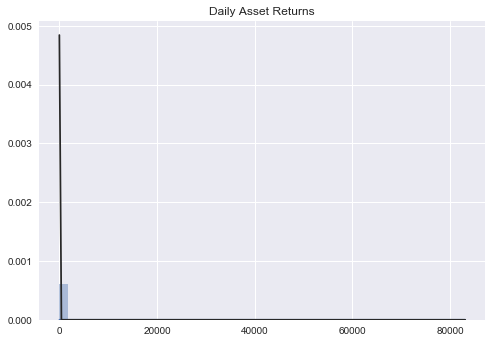

In [92]:
from scipy.stats import norm

sns.distplot(prices_df[['daily_ret']].dropna(), 
             bins=50, fit=norm)
plt.title('Daily Asset Returns')
plt.show()

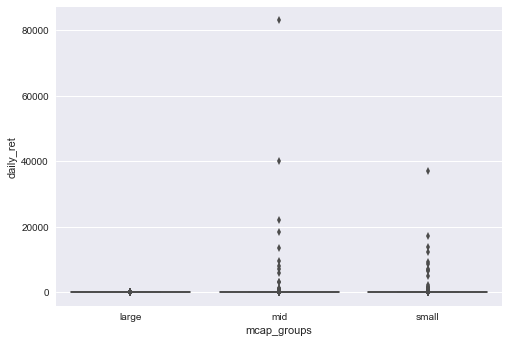

In [93]:
#There are massive outliers present in our smallest cap securities. 
#This isn't too surprising, but we will want to limit the affect they
#Have on our analysis
sns.boxplot(y='daily_ret', x='mcap_groups', data=prices_df, orient='v');

## Treating Outliers

In this section we will explore two methods for treating outliers. In the first method we will set bounds based on each assets' z-score, and in the other we will use percentile limits. Ultimately, the more robust of the two will be selected to treat our dataset. 

### Method 1: Z-Score

Apply z-scores to the daily returns and exclude companies with values that are > +/- 3 standard deviations from the mean.

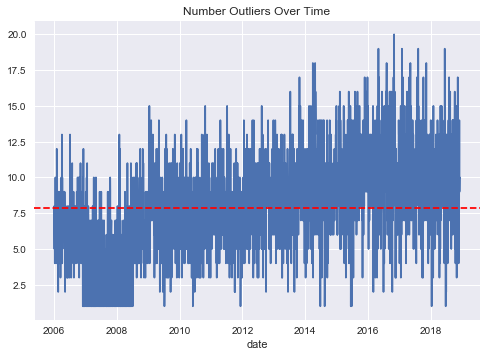

In [94]:
from scipy import stats

#Apply a z-score to standardize each assets' return
prices_df['daily_ret_z'] = prices_df['daily_ret'].groupby(level=0).transform(lambda x: stats.zscore(x))

#Plot the number of securities with daily returns greater than 3 std from the mean
num_outliers = prices_df[prices_df['daily_ret_z'].abs() > 3.]['daily_ret']\
.groupby(level=0).count()
num_outliers.plot(title='Number Outliers Over Time')
plt.axhline(num_outliers.mean(), linestyle='--', color='red')
plt.show()

This is an effective method however it seems there are more outliers present in the small cap group than I would like.  

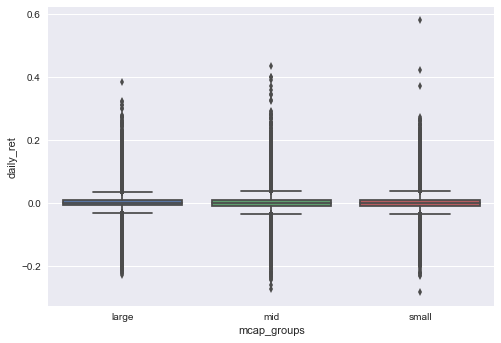

In [95]:
sns.boxplot(y='daily_ret', 
            x='mcap_groups', 
            data=prices_df[prices_df['daily_ret_z'].abs() < 3.], 
            orient='v');

### Method 2: Use Percentile Bounds

Create a series of cutoffs that represent the upper and lower bounds of returns that we'd like to use going forward.

In [100]:
upper_bound = .999 
lower_bound = .001
return_cutoffs = prices_df['daily_ret'].quantile([lower_bound, 
                                                  upper_bound]).values
print("Upper Bound: {:.3f}".format(return_cutoffs[1]))
print("Lower Bound: {:.3f}".format(return_cutoffs[0]))

Upper Bound: 0.157
Lower Bound: -0.136


In this scenario, using percentile bounds vs. z-score limits proves to be a more robust way to treat our dataset, so we'll stick with that approach when estimating our time-series exposures.

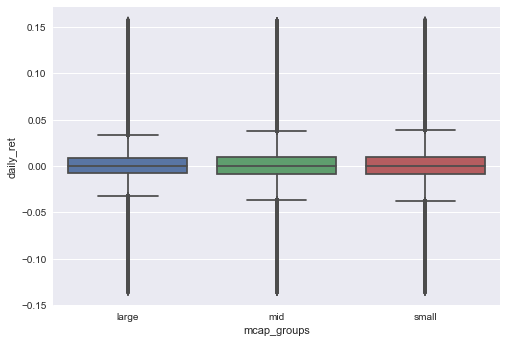

In [101]:
#Define the percentile filter based on the cutoffs
ret_filter = prices_df['daily_ret'].between(return_cutoffs[0],
                                            return_cutoffs[1], 
                                            inclusive=True)

sns.boxplot(y='daily_ret', x='mcap_groups',
            data=prices_df[ret_filter], 
            orient='v');

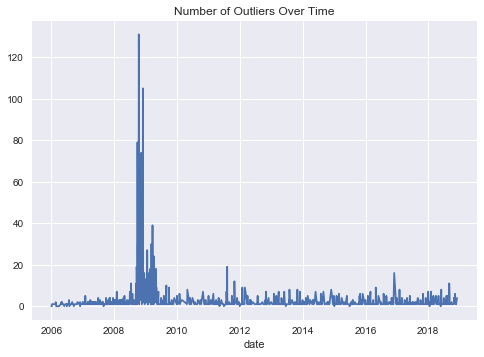

In [102]:
#Display the number of assets beyond the cutoffs
prices_df[ret_filter == False].groupby(level=0)['daily_ret'].count().plot()
plt.title('Number of Outliers Over Time')
plt.show()

Clip returns at the upper and lower bound then visualize the new distribution of daily returns. 

In [104]:
prices_df['daily_ret'].clip_upper(return_cutoffs[1], axis=0, inplace=True)
prices_df['daily_ret'].clip_lower(return_cutoffs[0], axis=0, inplace=True)

As you can see below, we've created a robust set of daily returns. We have taken the upper limit down from over 80,000% (!) to 60% with the z-score method and finally to +/- 15%. Our time-series exposures will benefit enormously by reducing the amount of noise in our return streams.

I read a number of articles and found this one particularly helpful (and simple!) when thinking through outlier methods to choose between: https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba

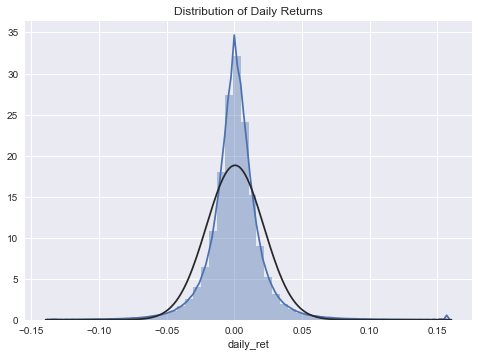

In [105]:
sns.distplot(prices_df['daily_ret'].dropna(), bins=50, fit=norm)
plt.title('Distribution of Daily Returns')
plt.show()

***

## Sectors Exposures

Now that we have a clean set of daily asset returns, we can move on to creating our exposures for sectors and style factors. Let's start with the sectors shown below:

    o Sectors:
        ▪ Beta to Communication Services (XLC)
        ▪ Beta to Consumer Discretionary (XLY)
        ▪ Beta to Consumer Staples (XLP)
        ▪ Beta to Energy (XLE)
        ▪ Beta to Financials (XLF)
        ▪ Beta to Health Care (XLV)
        ▪ Beta to Industrials (XLI)
        ▪ Beta to Materials (XLB)
        ▪ Beta to Technology (XLK)
        ▪ Beta to Utilities (XLU)    

In [107]:
etf_ids = ['XLY', 
           'XLP', 
           'XLE', 
           'XLF', 
           'XLV', 
           'XLI', 
           'XLB', 
           'XLK', 
           'XLU']

sector_betas_dict = {}
for etf in etf_ids:
    cov = prices_df.pivot_table(values='daily_ret',
                                index='date', 
                                columns='ticker').rolling(252, 
                                                          min_periods=(int(252*.8))).cov(etf_prices['daily_ret'].unstack()[etf])
    
    var = etf_prices['daily_ret'].unstack()[etf].rolling(252, 
                                                         min_periods=(int(252*.8))).var()
    
    sector_betas_dict[etf] = cov.apply(lambda x: x / var)

sector_betas = pd.DataFrame({k:v.stack() for k, v in sector_betas_dict.items()})

### Fama & French Exposures

Next, we'll compute a series of exposures for our Fama & French factors. Before doing that, we need to align the calendars between the two datasets. As of now, the Fama & French data is based on North American securities, so it's using a combination of US & Canadian trading days vs. US only.

In [113]:
us_dates = prices_df.index.get_level_values(0).unique()
ff_rets = ff_rets[ff_rets.index.isin(us_dates)]

In [114]:
ff_betas_dict = {}
for factor in ff_rets.columns:
    cov = prices_df.pivot_table(values='daily_ret',
                                index='date', 
                                columns='ticker').rolling(252, 
                                                          min_periods=(int(252*.8))).cov(ff_rets[factor]/100)
    
    var = (ff_rets[factor]/100).rolling(252, min_periods=(int(252*.8))).var()
    
    ff_betas_dict[factor] = cov.apply(lambda x: x / var)

ff_betas = pd.DataFrame({k:v.stack() for k, v in ff_betas_dict.items()})
ff_betas.drop('rf', axis=1, inplace=True)

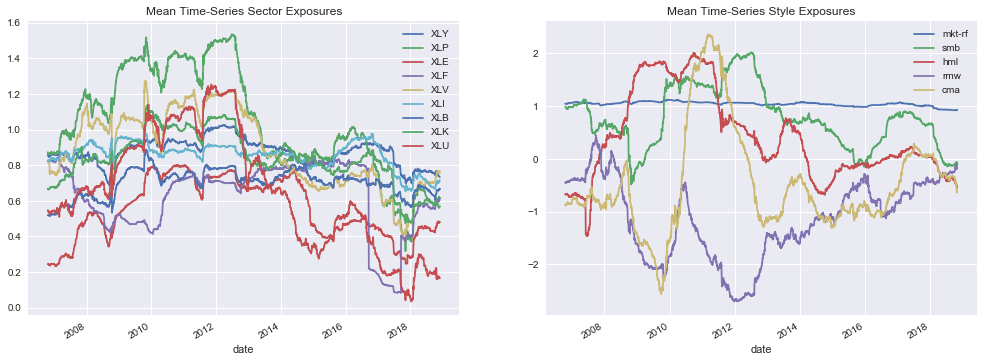

In [126]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(17, 6))

sector_betas.groupby(level=0).mean().plot(title='Mean Time-Series Sector Exposures', ax=ax1)

ff_betas.groupby(level=0).mean().plot(title='Mean Time-Series Style Exposures', ax=ax2);


### Technical Factors

    • Relative Strength Index (RSI)
    • Moving Average Signal Convergence Divergence (MACD)
    • Long-Term Momentum: Price change over several horizons
    • Short-Term Reversal: Price change over several near-term horizons
    • Percent above and below the 52-week high and low price
    • Percent above and below the 30 and 200 days moving average price
    • Volatility: Standard deviation of returns over several horizons
    • Money Flow Index
    • Directional Movement Index (DX)
    • Stochastic Oscillator
    • Average True Range (ATR)

Below we'll use `pandas` to begin this process.

- % Above/Below Moving Average Price - 30 day, 50 day, and 200 day
- % Above/Below 52 week high and low price
- Binary flags for if current price > 30d_mavg; 30d_mavg > 50d_mavg; 50d_mavg > 200d_mavg

In [68]:
#Unstack data to create a time-series view
adj_close = prices_df.pivot_table(values=['adj_close'],
                                  index='date', 
                                  columns='ticker').fillna(method='ffill')

fast_period = 30
med_period = 50
slow_period = 200
factor_data = {}
for period in [fast_period, med_period, slow_period]:
    """
    All moving averages require at least 80% of the underlying
    data points to be available.
    """
    factor_data[str(period)+'d_mavg'] = adj_close['adj_close'].rolling(period, 
                                                                  min_periods=(int(period*.8))).mean().stack()
    
factor_data = pd.DataFrame(factor_data)

In [69]:
factor_data = pd.merge(factor_data, 
                       prices_df[['adj_close', 'mcap_groups']],
                       how='outer', 
                       right_index=True, 
                       left_index=True)

Binary Moving Average Indicators

In [70]:
#Price > 30D Moving Average Price
factor_data['p_gt_30d'] = np.where(factor_data['adj_close'] > factor_data['30d_mavg'], 1, 0)

#Price > 50D Moving Average Price
factor_data['p_gt_50d'] = np.where(factor_data['adj_close'] > factor_data['50d_mavg'], 1, 0)

#Price > 200D Moving Average Price
factor_data['p_gt_200d'] = np.where(factor_data['adj_close'] > factor_data['200d_mavg'], 1, 0)

#30D Moving Average Price > 50D Moving Average Price
factor_data['30d_gt_50d'] = np.where(factor_data['30d_mavg'] > factor_data['50d_mavg'], 1, 0)

#50D Moving Average Price > 200D Moving Average Price
factor_data['50d_gt_200d'] = np.where(factor_data['50d_mavg'] > factor_data['200d_mavg'], 1, 0)

Percent Change from Moving Averages

In [71]:
#Percent above 30d moving average
factor_data['perc_above30d'] = (factor_data['adj_close'] / factor_data['30d_mavg'] - 1) * 100

#Percent above 50d moving average
factor_data['perc_above50d'] = (factor_data['adj_close'] / factor_data['50d_mavg'] - 1) * 100

#Percent above 200d moving average
factor_data['perc_above200d'] = (factor_data['adj_close'] / factor_data['200d_mavg'] - 1) * 100

Calculate Percent Above and Below the 52 Week High & Low

In [72]:
#1yr high & low prices
factor_data['oneyr_high'] = adj_close['adj_close'].rolling(252, 
                                                           min_periods=int(252*.8)).max().stack()

factor_data['oneyr_low'] = adj_close['adj_close'].rolling(252, 
                                                          min_periods=int(252*.8)).min().stack()

In [73]:
#Percent above 52 week high
factor_data['perc_above52wh'] = (factor_data['adj_close'] / factor_data['oneyr_high'] - 1) * 100

#Percent above 52 week low
factor_data['perc_above52wl'] = (factor_data['adj_close'] / factor_data['oneyr_low'] - 1) * 100

Define long-term & short-term momentum:

- Long-term Momentum: 12M - 1M Price Change
- Medium-term Momentum: 6M - 1M Price Change
- Short-term Momentum: Price change over most recent month

In [74]:
#Long-term momentum - 12 - 1M price momentum
factor_data['lt_momentum'] = adj_close.apply(lambda x: x.shift(21) / x.shift(252) - 1).stack()

#Medium-term momentum - 6 - 1M price momentum
factor_data['mt_momentum'] = adj_close.apply(lambda x: x.shift(21) / x.shift(126) - 1).stack()

#Short-term momentum
factor_data['st_momentum'] = adj_close.apply(lambda x: x / x.shift(21) - 1).stack()

Define stock price volatility over 1, 3, 6, and 12 months

In [75]:
#Query daily returns
daily_rets = prices_df.pivot_table(values=['daily_ret'],
                                   index='date', 
                                   columns='ticker')

#Define horizons for volatility factors
vol_horizons = [x*21 for x in [1, 3, 6, 12]]

for period in vol_horizons:
    """
    All volatilities require at least 80% of the underlying
    data points to be available.
    """
    factor_data[str(period)+'d_vol'] = (daily_rets['daily_ret'].rolling(period, 
                                                                  min_periods=(int(period*.8)))\
                                      .std() * np.sqrt(252)).stack()

Construct technical factors using `talib`
    
    • Relative Strength Index (RSI)
    • Moving Average Signal Convergence Divergence (MACD)
    • On Balance Volume (OBV)
    • Money Flow Index
    • Directional Movement Index (DX)
    • Stochastic Oscillator
    • Average True Range (ATR)      

In [82]:
import talib as ta

pricing_pivot = prices_df.pivot_table(values=['high', 'low', 'open', 'close', 'volume', 'adj_close'],
                                      index='date', 
                                      columns='ticker').fillna(method='ffill')

In [95]:
#RSI
factor_data['RSI'] = adj_close.apply(lambda x: ta.RSI(x, timeperiod=14)).stack()

#MACD
for i, signal in enumerate(['macd', 'macdsignal', 'macdhist']):
    factor_data[signal] = adj_close['adj_close']\
    .apply(lambda x: ta.MACD(x, 
                             fastperiod=12, 
                             slowperiod=26, 
                             signalperiod=9)[i]).stack()

#BOP, MFI, DX, STOCH_OSC, ATR
bop = {}
mfi = {}
dx = {}
stoch_osc = {}
ATR = {}
for i, sec in enumerate(pricing_pivot['adj_close'].columns.tolist()):
    open_p = pricing_pivot['open'].iloc[:, i]
    high = pricing_pivot['high'].iloc[:, i]
    low = pricing_pivot['low'].iloc[:, i]
    close = pricing_pivot['close'].iloc[:, i]
    volume = pricing_pivot['volume'].iloc[:, i]
    
    try:        
        bop[sec] = ta.BOP(open_p, high, low, close)
        mfi[sec] = ta.MFI(high, low, close, volume, timeperiod=14)
        dx[sec] = ta.DX(high, low, close, timeperiod=14)
        stoch_osc[sec] = ta.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
        ATR[sec] = ta.ATR(high, low, close, timeperiod=14)      
        
    except:
        pass

Combine dictionaries for technical factors

In [99]:
tech_factor_dictionaries = [bop, mfi, dx, stoch_osc, ATR]
tech_factor_names = ['bop', 'mfi', 'dx', 'stoch_osc', 'atr']
tech = []
for factor, col in zip(tech_factor_dictionaries, tech_factor_names):
    df = pd.DataFrame(pd.concat(factor), columns=[col])
    df = df.swaplevel()
    df.sort_index(level=0, inplace=True)
    tech.append(df)
    
tech_factors = pd.concat(tech, axis=1)
tech_factors.index.names = ['date', 'ticker']

Join all factors together

In [105]:
all_factors = pd.merge(factor_data, 
                       tech_factors, 
                       how='outer', 
                       right_index=True,
                       left_index=True)

betas = pd.merge(ff_betas, 
                 sector_betas, 
                 how='outer',
                 right_index=True, 
                 left_index=True)

all_factors = pd.merge(all_factors, 
                       betas, 
                       how='outer',
                       right_index=True, 
                       left_index=True)

Write final factor data to csv

In [106]:
all_factors.to_csv('data//all_factors.csv')

***

<a id='step1'></a>
# Exploratory Data Analysis on Features

**INSERT INFORMATION HERE ABOUT THE ROUTINE. INCLUDE ANALYZING RELATIONSHIPS, TREATING OUTLIERS USING THE IQR, AND SETTING START AND END DATES FOR THE ANALYSIS**

https://kite.com/blog/python/data-analysis-visualization-python

https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-1-exploratory-data-analysis-with-pandas-de57880f1a68

https://machinelearningmastery.com/visualize-machine-learning-data-python-pandas/

https://github.com/WillKoehrsen/machine-learning-project-walkthrough/blob/master/Machine%20Learning%20Project%20Part%201.ipynb

In [4]:
#RUN ON AWS
all_factors = pd.read_csv('all_factors.csv', 
                          index_col=['date', 'ticker'])

In [3]:
all_factors = pd.read_csv('data//all_factors.csv', 
                          index_col=['date', 'ticker'])

all_factors = all_factors[~all_factors['adj_close'].isnull()]

ff_factors = ['mkt-rf', 
              'smb', 
              'hml', 
              'rmw', 
              'cma']

sector_betas = ['XLY', 
                'XLP', 
                'XLE', 
                'XLF', 
                'XLV', 
                'XLI', 
                'XLB', 
                'XLK', 
                'XLU']

technical_factors = ['RSI', 
                     'macd', 
                     'macdsignal', 
                     'macdhist', 
                     'bop', 
                     'mfi', 
                     'dx', 
                     'stoch_osc', 
                     'atr']
                     
momentum_vol = ['lt_momentum', 
                'mt_momentum', 
                'st_momentum',
                '21d_vol', 
                '63d_vol', 
                '126d_vol', 
                '252d_vol'] 
                     

pricing_factors = ['perc_above30d', 
                   'perc_above50d',
                   'perc_above200d', 
                   'perc_above52wh',
                   'perc_above52wl']

In [4]:
all_factors.head()

30d_mavg  50d_mavg  200d_mavg  adj_close mcap_groups  \
date       ticker                                                         
2005-12-30 A            NaN       NaN        NaN  20.707289       large   
           AA           NaN       NaN        NaN  59.385357       large   
           AAP          NaN       NaN        NaN  41.403198       small   
           AAPL         NaN       NaN        NaN   6.877439       large   
           ABC          NaN       NaN        NaN  16.766708         mid   

                   p_gt_30d  p_gt_50d  p_gt_200d  30d_gt_50d  50d_gt_200d  \
date       ticker                                                           
2005-12-30 A            0.0       0.0        0.0         0.0          0.0   
           AA           0.0       0.0        0.0         0.0          0.0   
           AAP          0.0       0.0        0.0         0.0          0.0   
           AAPL         0.0       0.0        0.0         0.0          0.0   
           ABC          0.0       0.0        0.0         0.0          0.0   

                  ...   cma  XLY  XLP  XLE  XLF  XLV  XLI  XLB  XLK  XLU  
date       ticker ...                                                     
2005-12-30 A      ...   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
           AA     ...   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
           AAP    ...   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
           AAPL   ...   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
           ABC    ...   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[5 rows x 47 columns]

In [7]:
all_factors.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1848813 entries, (2005-12-30, A) to (2018-11-30, ZTS)
Data columns (total 47 columns):
30d_mavg          float64
50d_mavg          float64
200d_mavg         float64
adj_close         float64
mcap_groups       object
p_gt_30d          float64
p_gt_50d          float64
p_gt_200d         float64
30d_gt_50d        float64
50d_gt_200d       float64
perc_above30d     float64
perc_above50d     float64
perc_above200d    float64
oneyr_high        float64
oneyr_low         float64
perc_above52wh    float64
perc_above52wl    float64
lt_momentum       float64
mt_momentum       float64
st_momentum       float64
21d_vol           float64
63d_vol           float64
126d_vol          float64
252d_vol          float64
RSI               float64
macd              float64
macdsignal        float64
macdhist          float64
bop               float64
mfi               float64
dx                float64
stoch_osc         float64
atr               float64
mkt-rf

In [5]:
all_factors.describe().round(2)

,30d_mavg,50d_mavg,200d_mavg,adj_close,p_gt_30d,p_gt_50d,p_gt_200d,30d_gt_50d,50d_gt_200d,perc_above30d,...,cma,XLY,XLP,XLE,XLF,XLV,XLI,XLB,XLK,XLU
count,1824303.00,1809482.00,1705022.00,1848813.00,1848813.00,1848813.00,1848813.00,1848813.00,1848813.00,1824303.00,...,1553381.00,1566123.00,1566123.00,1566123.00,1566123.00,1566123.00,1566123.00,1566123.00,1566123.00,1566123.00
mean,353.36,353.51,352.06,353.25,0.58,0.59,0.62,0.59,0.63,0.67,...,-0.44,0.87,1.01,0.55,0.62,0.87,0.85,0.70,0.83,0.63
std,7372.67,7360.73,7273.52,7494.60,0.49,0.49,0.48,0.49,0.48,7.35,...,1.40,0.33,0.45,0.32,0.32,0.37,0.33,0.30,0.35,0.43
min,5.00,5.00,5.01,5.00,0.00,0.00,0.00,0.00,0.00,-99.99,...,-9.69,-0.95,-0.84,-0.42,-0.77,-0.48,-0.60,-0.43,-0.73,-1.03
25%,24.21,24.21,24.10,24.19,0.00,0.00,0.00,0.00,0.00,-2.25,...,-1.10,0.65,0.72,0.32,0.39,0.62,0.63,0.49,0.58,0.33
50%,39.83,39.79,39.39,39.86,1.00,1.00,1.00,1.00,1.00,0.92,...,-0.40,0.86,0.94,0.50,0.62,0.82,0.84,0.68,0.80,0.58
75%,66.76,66.59,65.21,66.98,1.00,1.00,1.00,1.00,1.00,3.79,...,0.21,1.08,1.24,0.73,0.84,1.09,1.07,0.88,1.05,0.91
max,323866.90,319905.38,305362.96,964377.94,1.00,1.00,1.00,1.00,1.00,1889.64,...,5.78,3.03,3.35,2.44,2.45,2.95,2.52,2.77,3.36,2.67


Create target variable (1D, 5D, 21D, 42D, 63D forward return horizons)

In [4]:
fwd_ret_horizons = [1, 5, 21, 42, 63]
for ret in fwd_ret_horizons:
    all_factors['fwdret_' + str(ret) + 'd'] = all_factors.pivot_table(values='adj_close',
                                                                      index='date', 
                                                                      columns='ticker').pct_change(ret).shift(-ret).stack()

Binarize forward return horizons

In [5]:
all_factors[['fwdret_1d_target',
             'fwdret_5d_target', 
             'fwdret_21d_target', 
             'fwdret_42d_target', 
             'fwdret_63d_target']] = all_factors[['fwdret_1d',
                                                  'fwdret_5d', 
                                                  'fwdret_21d', 
                                                  'fwdret_42d', 
                                                  'fwdret_63d']].groupby(level=0)\
.transform(lambda x: np.where(x > x.median(), 1, 0))

Check start and end dates for factors by category:

In [7]:
def StartAndEndDates(factor_list):
    for factor in factor_list:
        mask = all_factors[factor].notnull()
        start_date = all_factors.loc[mask, [factor]].index.get_level_values(0).unique()[0]
        end_date = all_factors.loc[mask, [factor]].index.get_level_values(0).unique()[-1]
        print("    {}: Begins on - {} & Ends on - {}".format(factor, start_date, end_date))

print("Start & End dates for Sector Exposures: \n")
StartAndEndDates(sector_betas)

print("\n Start & End dates for Fama French Exposures: \n")
StartAndEndDates(ff_factors)

print("\n Start & End dates for Technical Exposures: \n")
StartAndEndDates(technical_factors)

print("\n Start & End dates for Pricing Exposures: \n")
StartAndEndDates(pricing_factors)

print("\n Start & End dates for Forward Returns: \n")
StartAndEndDates(['fwdret_' + str(x) + 'd' for x in fwd_ret_horizons])  

Start & End dates for Sector Exposures: 

    XLY: Begins on - 2006-10-19 & Ends on - 2018-11-30
    XLP: Begins on - 2006-10-19 & Ends on - 2018-11-30
    XLE: Begins on - 2006-10-19 & Ends on - 2018-11-30
    XLF: Begins on - 2006-10-19 & Ends on - 2018-11-30
    XLV: Begins on - 2006-10-19 & Ends on - 2018-11-30
    XLI: Begins on - 2006-10-19 & Ends on - 2018-11-30
    XLB: Begins on - 2006-10-19 & Ends on - 2018-11-30
    XLK: Begins on - 2006-10-19 & Ends on - 2018-11-30
    XLU: Begins on - 2006-10-19 & Ends on - 2018-11-30

 Start & End dates for Fama French Exposures: 

    mkt-rf: Begins on - 2006-10-19 & Ends on - 2018-10-31
    smb: Begins on - 2006-10-19 & Ends on - 2018-10-31
    hml: Begins on - 2006-10-19 & Ends on - 2018-10-31
    rmw: Begins on - 2006-10-19 & Ends on - 2018-10-31
    cma: Begins on - 2006-10-19 & Ends on - 2018-10-31

 Start & End dates for Technical Exposures: 

    RSI: Begins on - 2006-01-23 & Ends on - 2018-11-30
    macd: Begins on - 2006-02-17 &

In [6]:
#Keep a date range of 2007-01-05 to 2018-08-29
all_factors = all_factors.loc['2007-01-05':'2018-08-29']

In [10]:
#Count number of missing fields
total_missing = all_factors.isnull().sum()
percent = (total_missing / len(all_factors)) * 100
pd.DataFrame({'Total': total_missing, 
              'Percent(%)': percent.round(1)}).sort_values('Percent(%)', 
                                                  ascending=False).round(3)

,Total,Percent(%)
252d_vol,185820,11.0
mkt-rf,185820,11.0
XLK,186177,11.0
XLB,186177,11.0
XLI,186177,11.0
XLV,186177,11.0
XLF,186177,11.0
XLE,186177,11.0
XLP,186177,11.0
XLY,186177,11.0


one-hot encode market cap groups

In [7]:
all_factors = pd.merge(all_factors,
                       pd.get_dummies(all_factors['mcap_groups']),
                       how='left',
                       left_index=True,
                       right_index=True                      
                      )

In [18]:
#all_factors = all_factors.join(pd.get_dummies(all_factors['mcap_groups']), 
#                               on=['date', 'ticker'],
#                               how='left')

Resample data to understand relationships present in the data

In [12]:
num_samples = 100
random_dates = all_factors.sample(num_samples, random_state=2).index.get_level_values(0).unique()
resampled_df = all_factors[all_factors.index.get_level_values(0).isin(random_dates)]

Analyze distributions within market cap segments. 

Fama French & Sector betas appear to follow a guassian distribution within reason. This makes sense given the outlier handling that was applied prior to constructing those features.

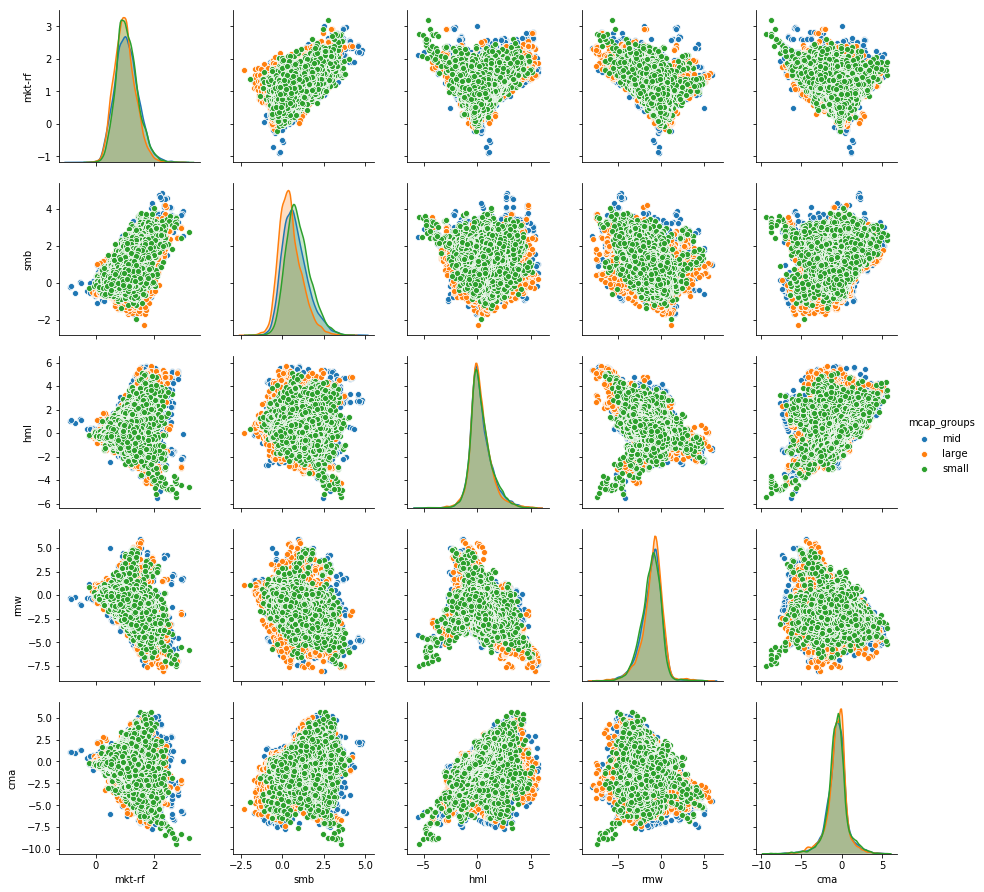

In [13]:
import seaborn as sns
sns.pairplot(resampled_df[ff_factors + ['mcap_groups']].dropna(), 
             diag_kind='kde', 
             hue='mcap_groups');

C:\Users\jimportico\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


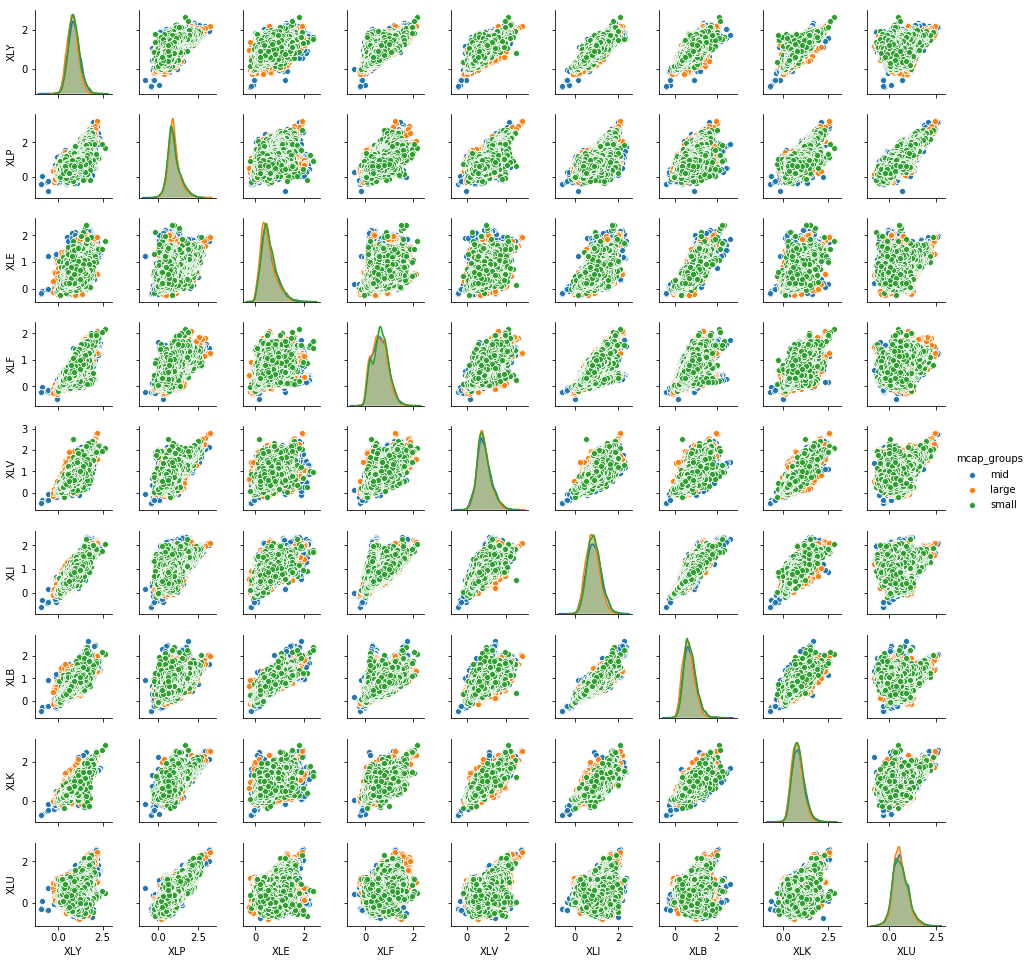

In [14]:
sns.pairplot(resampled_df[sector_betas + ['mcap_groups']].dropna(), 
             diag_kind='kde', 
             hue='mcap_groups', 
             size=1.5);

C:\Users\jimportico\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


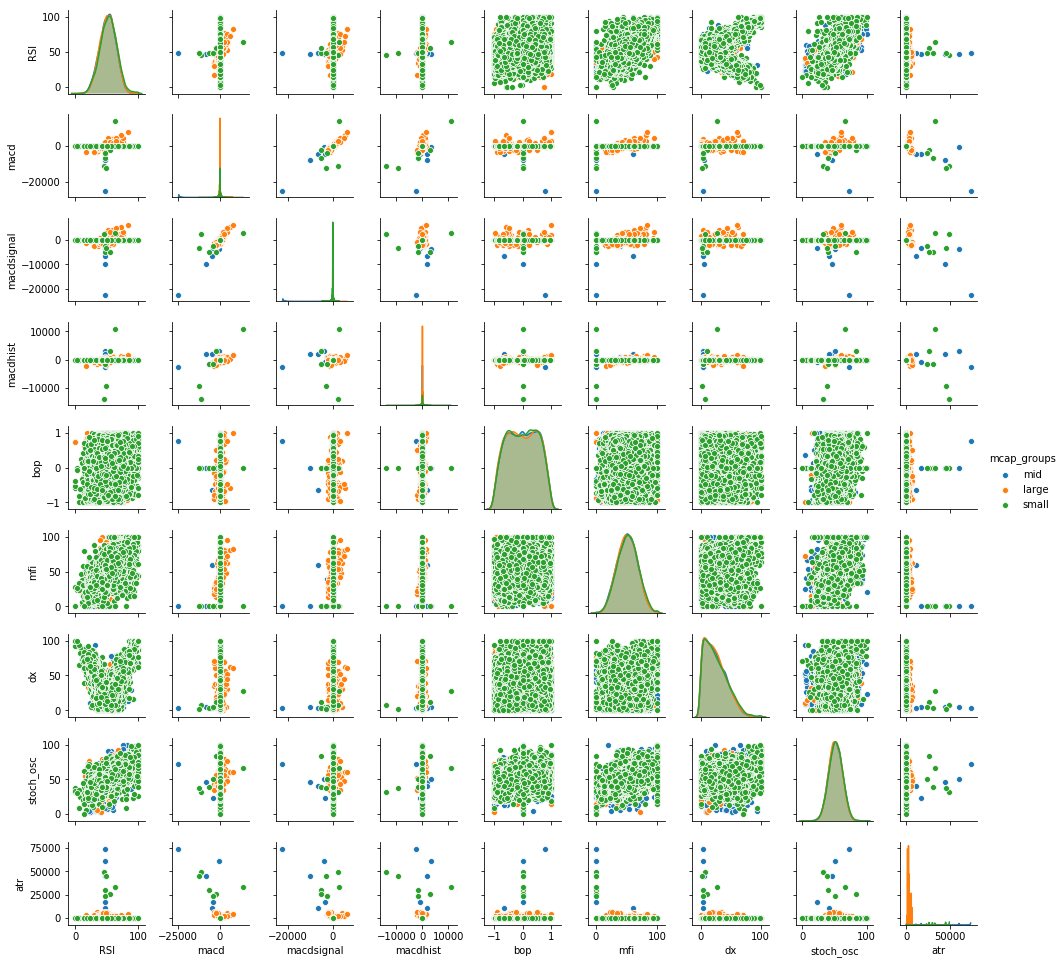

In [15]:
sns.pairplot(resampled_df[technical_factors + ['mcap_groups']].dropna(), 
             diag_kind='kde',  
             hue='mcap_groups', 
             size=1.5);

C:\Users\jimportico\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


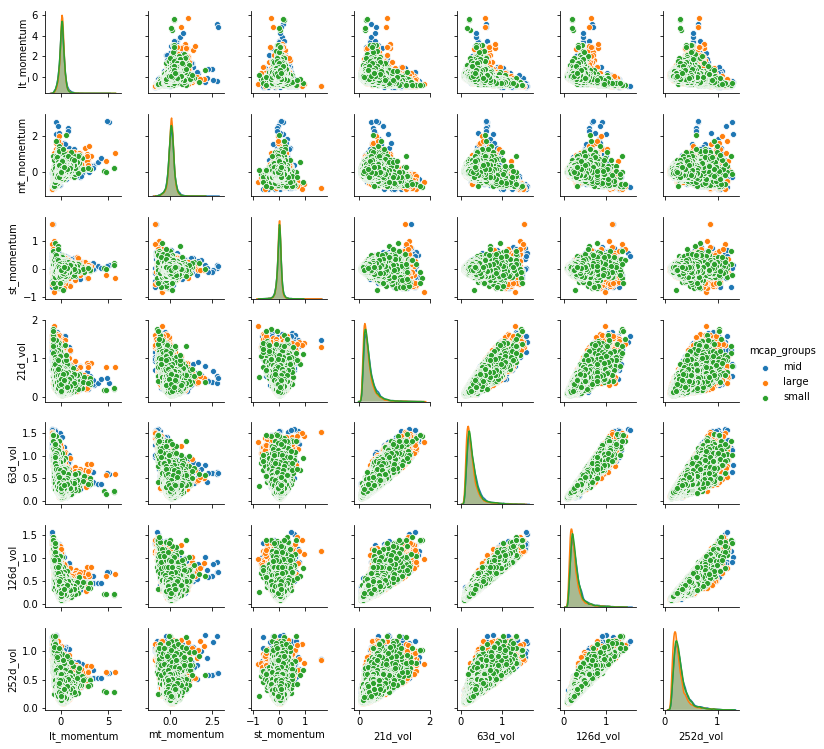

In [16]:
sns.pairplot(resampled_df[momentum_vol + ['mcap_groups']].dropna(), 
             diag_kind='kde',  
             hue='mcap_groups', 
             size=1.5);

C:\Users\jimportico\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


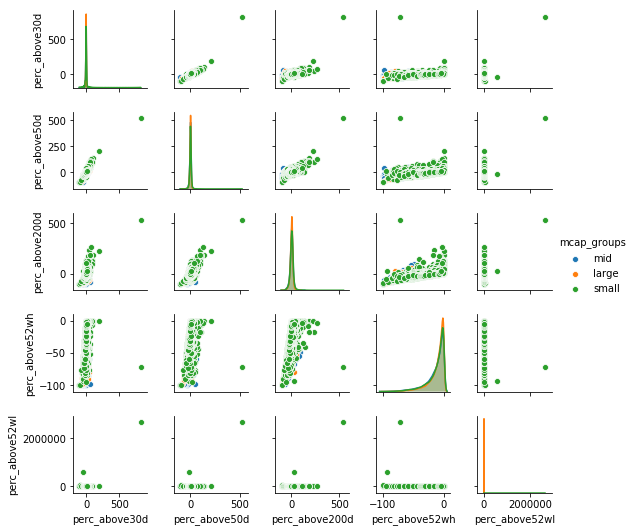

In [17]:
sns.pairplot(resampled_df[pricing_factors + ['mcap_groups']].dropna(), 
             diag_kind='kde',  
             hue='mcap_groups', 
             size=1.5);

In [8]:
features = ff_factors +\
sector_betas +\
technical_factors +\
momentum_vol +\
pricing_factors +\
['large', 'mid', 'small']

**Univariate Plots**

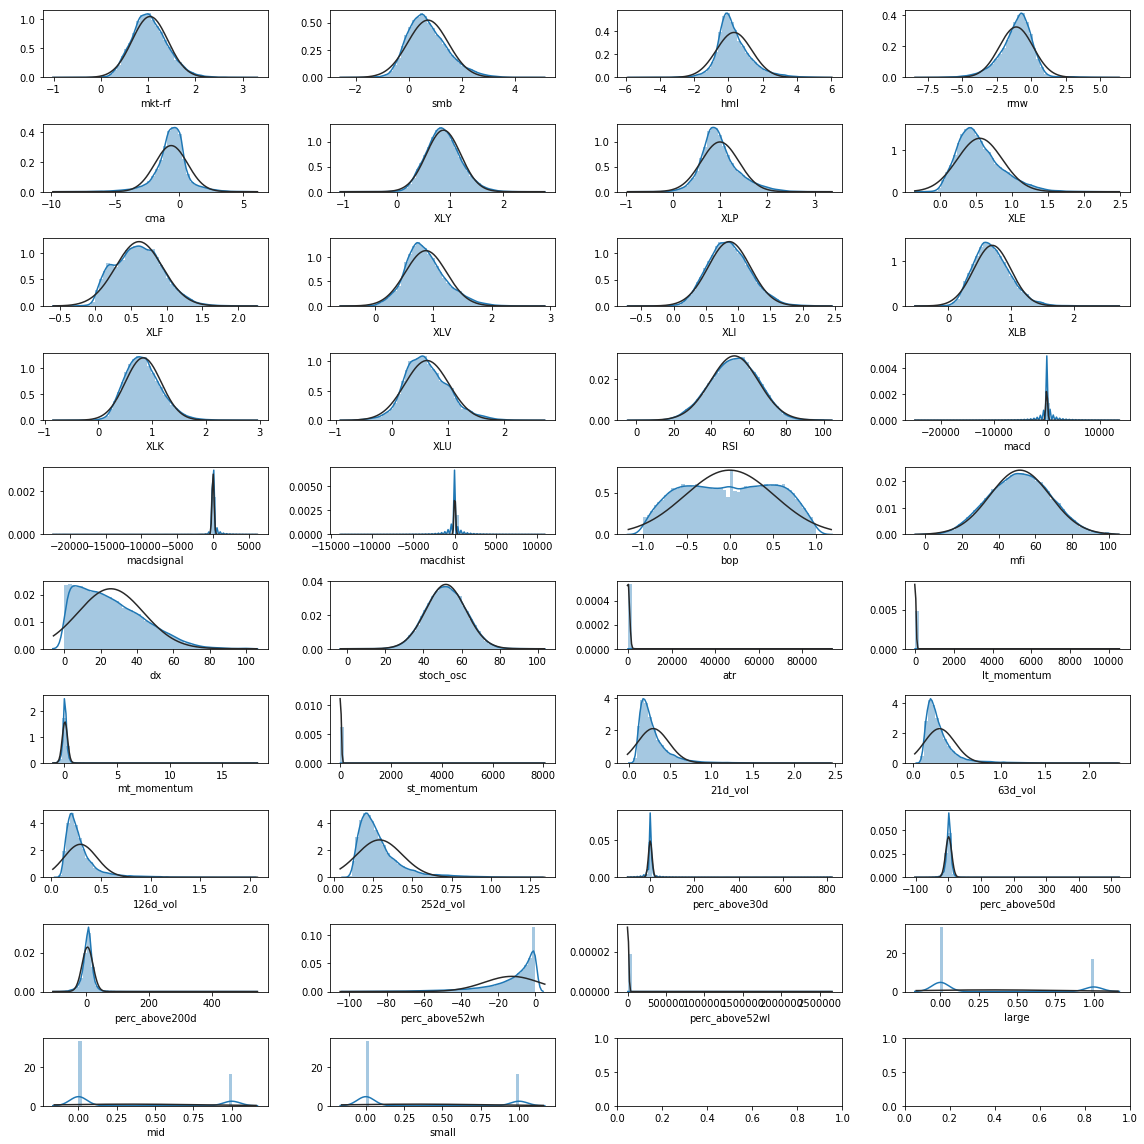

In [19]:
import copy
from scipy.stats import norm
import seaborn as sns

mask = features
ncols = 4
nrows = -(-len(mask)//ncols)
f, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(16, 16), sharex=False)
for d, ax in zip(mask, axes.flat):
    sns.distplot(resampled_df[d].dropna(), ax=ax, bins=50, fit=norm)

plt.tight_layout()

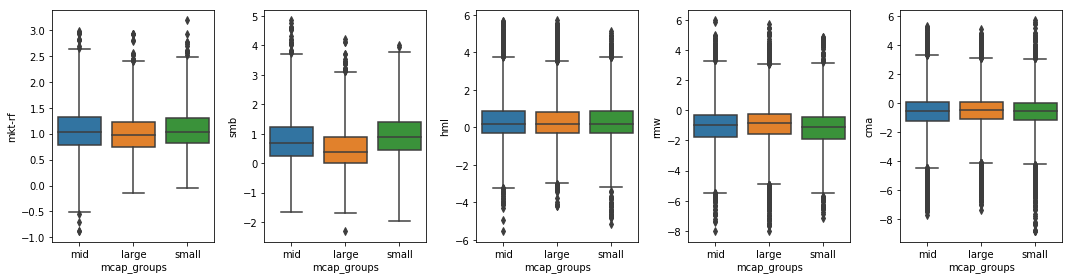

In [20]:
def box_plot(dataframe, features, group, 
             nrows, ncols, fwd_ret_horizon, figsize, quantiles=5):
    """
    dataframe: df with all data to be visualized
        features: Attributes / columns within the dataframe
    group: Categorical classifier 
    nrows/ncols: number of rows & columns for the charts
    fwd_ret_horizon: input the dependent (target) variable for multivariate plotting
    figsize: size of the plots being output
    quantiles: Sets number of quantiles for multivariate plots
    """
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

    for feature, ax in zip(features, axes.flatten()):
        if fwd_ret_horizon is None:
            sns.boxplot(x=group, y=str(feature), data=dataframe.dropna(), 
                        orient='v', whis=2.5, ax=ax)    
            
        else:            
            df = dataframe[[feature, fwd_ret_horizon]].copy()  
            df[str(feature)+'_quantiles'] = df.groupby(level=0)[feature]\
            .transform(lambda x: pd.qcut(x, 
                                         q=quantiles,
                                         duplicates='drop',
                                         labels=False))    
            
            sns.boxplot(y=fwd_ret_horizon, x=str(feature)+'_quantiles', 
                        data=df.dropna(), orient='v', whis=2.5, ax=ax)    
    
    fig.tight_layout()
    
box_plot(resampled_df, ff_factors, group='mcap_groups', 
         nrows=1, ncols=5, fwd_ret_horizon=None, figsize=(15, 4), quantiles=5)

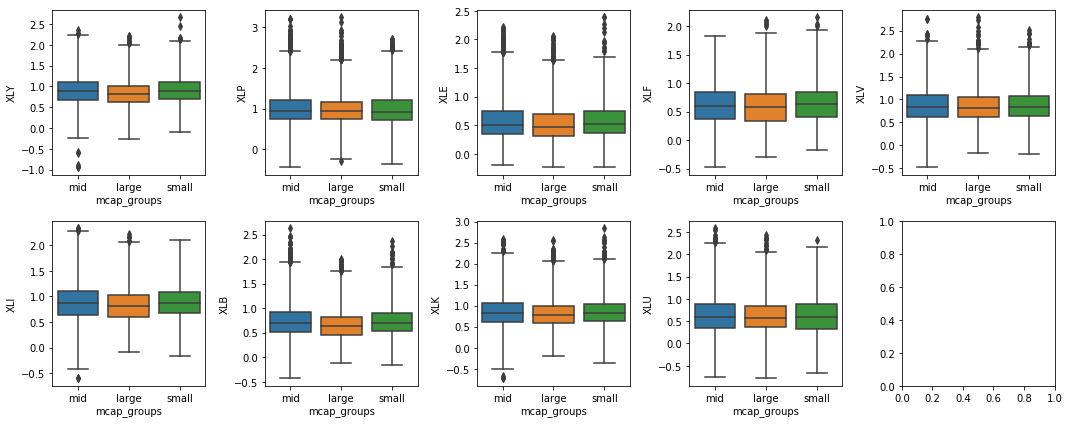

In [21]:
box_plot(resampled_df, sector_betas, group='mcap_groups', 
         nrows=2, ncols=5, fwd_ret_horizon=None, figsize=(15, 6), quantiles=5)

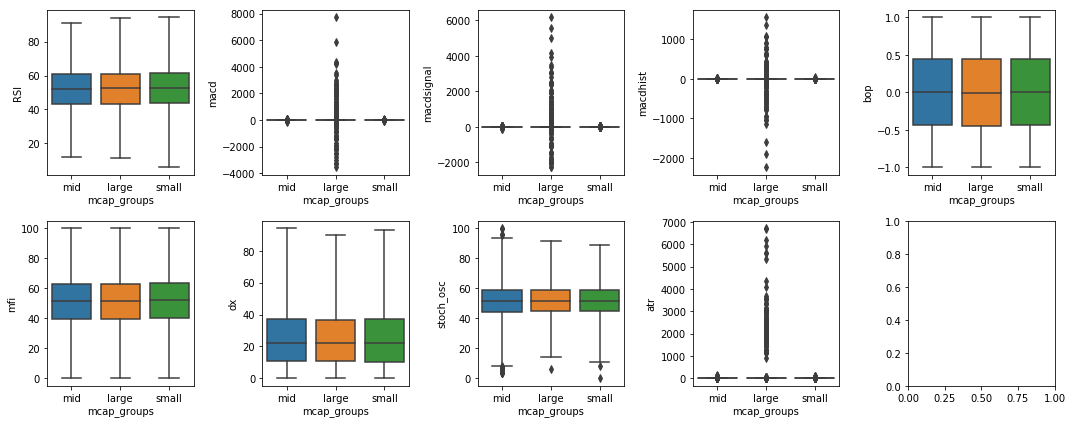

In [22]:
box_plot(resampled_df, technical_factors, group='mcap_groups', 
         nrows=2, ncols=5, fwd_ret_horizon=None, figsize=(15, 6), quantiles=5)

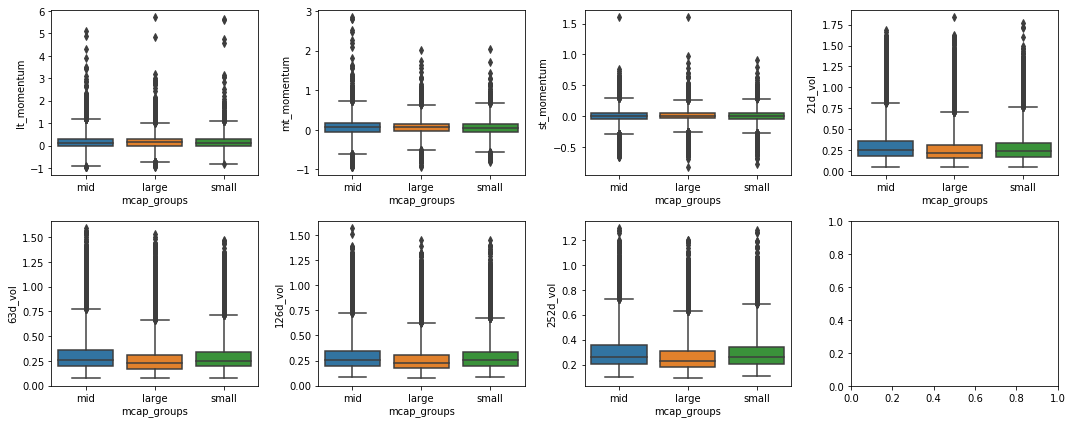

In [23]:
box_plot(resampled_df, momentum_vol, group='mcap_groups', 
         nrows=2, ncols=4, fwd_ret_horizon=None, figsize=(15, 6), quantiles=5)

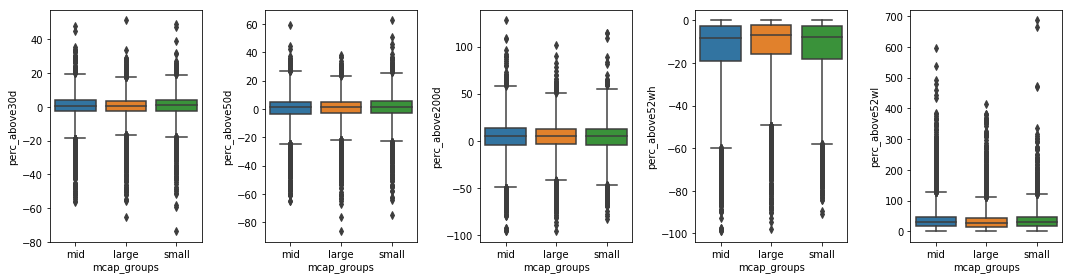

In [24]:
box_plot(resampled_df, pricing_factors, group='mcap_groups', 
         nrows=1, ncols=5, fwd_ret_horizon=None, figsize=(15, 4), quantiles=5)

Treat features for outliers

In [9]:
def iqr(x, q):
    q1, q3 = np.percentile(x.dropna(), q)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    return x.clip(lower_bound, upper_bound)

all_factors = all_factors.groupby(level=0).transform(lambda x: iqr(x, [25, 75]))

Transform heavily skewed features:

- dx
- 21d_vol
- 63d_vol
- 126d_vol
- 252d_vol
- perc_above52wh
- perc_above52wl

In [10]:
all_factors[['dx']] = all_factors[['dx']].apply(lambda x: np.log(x + 1.))

all_factors[['21d_vol', 
             '63d_vol', 
             '126d_vol', 
             '252d_vol']] = all_factors[['21d_vol', 
                                         '63d_vol', 
                                         '126d_vol', 
                                         '252d_vol']].apply(lambda x: np.log(x + 1.))

all_factors[['perc_above52wh']] = all_factors[['perc_above52wh']].apply(lambda x: np.log(x / 100. + 1))

all_factors[['perc_above52wl']] = all_factors[['perc_above52wl']].apply(lambda x: np.log(x / 100. + 1))

Resample data with new outlier handling in place

In [27]:
num_samples = 100
random_dates = all_factors.sample(num_samples, 
                                  random_state=2).index.get_level_values(0).unique()
resampled_df = all_factors[all_factors.index\
                           .get_level_values(0).isin(random_dates)]

Re-run histograms to test the distributions

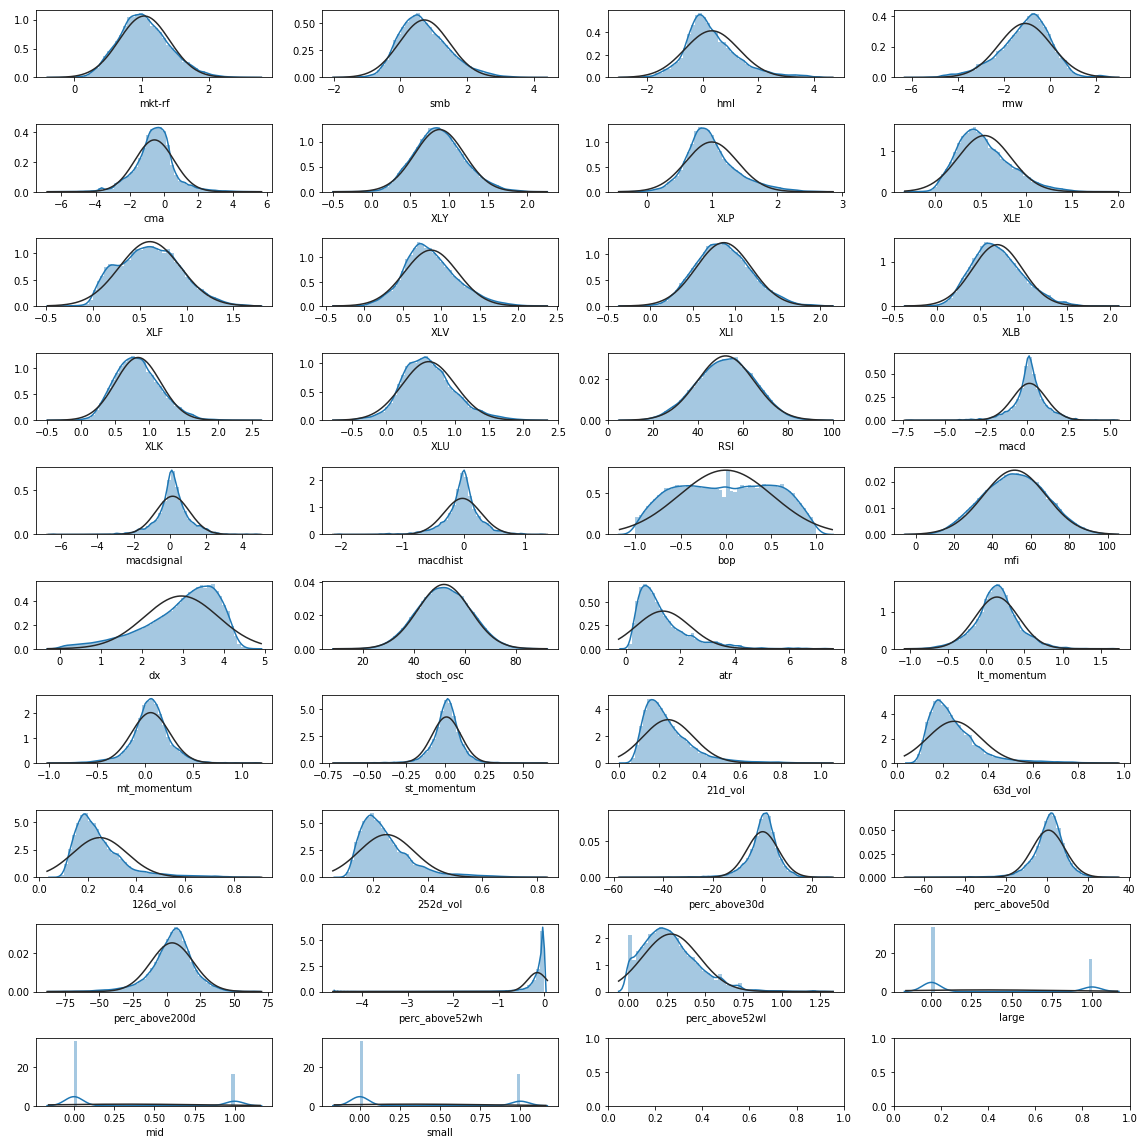

In [28]:
mask = features
ncols = 4
nrows = -(-len(mask)//ncols)
f, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(16, 16), sharex=False)
for d, ax in zip(mask, axes.flat):
    sns.distplot(resampled_df[d].dropna(), ax=ax, bins=50, fit=norm)

plt.tight_layout()

Visualize Correlations

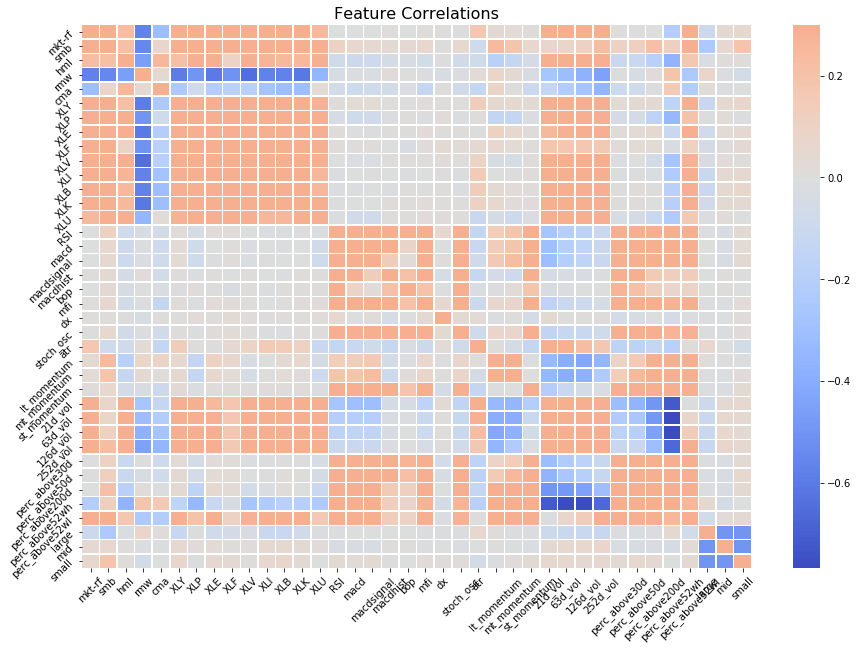

In [51]:
corrs = resampled_df[features].corr()
fig, ax = plt.subplots(figsize=(15,10)) 

sns.heatmap(corrs, 
            vmax=.3, 
            center=0, 
            cmap='coolwarm', 
            square=False, 
            linewidths=.5, 
            annot=False, 
            cbar_kws={'shrink': 1.})
plt.yticks(rotation=45) 
plt.xticks(rotation=45) 
plt.title('Feature Correlations', fontsize=16)
plt.show()

Identify all correlations above and below +/- .5

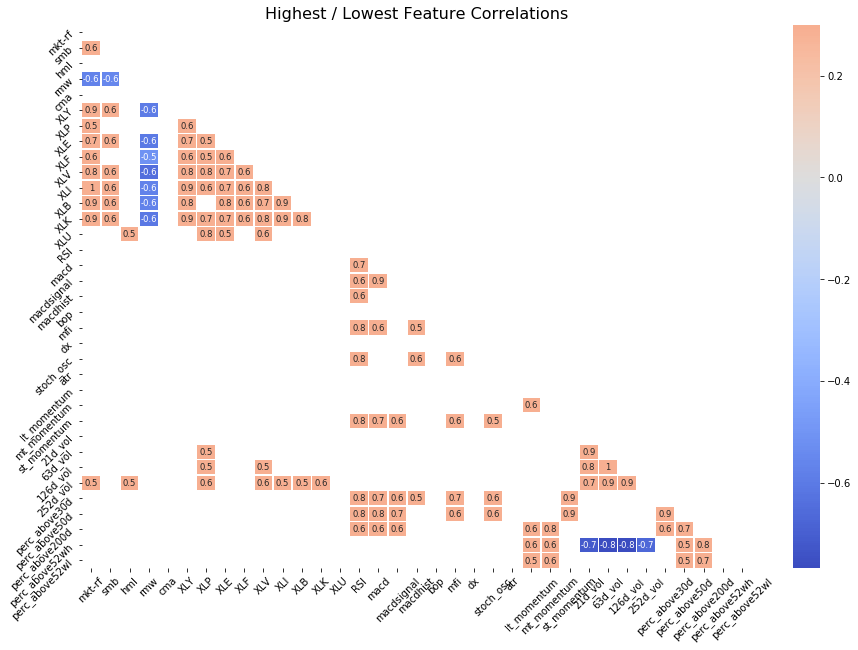

In [30]:
fig, ax = plt.subplots(figsize=(15,10)) 
lower_corrs = corrs.where(np.tril(np.ones(corrs.shape), 
                                  k=-1).astype(np.bool))

corr_threshold = .5
sns.heatmap(lower_corrs[lower_corrs.abs() > corr_threshold], 
            vmax=.3, 
            center=0, 
            cmap='coolwarm', 
            square=False, 
            linewidths=.5, 
            annot=True, fmt='.1g', 
            annot_kws={"size": 8.5}, 
            cbar_kws={'shrink': 1.})
plt.yticks(rotation=45) 
plt.xticks(rotation=45) 
plt.title('Highest / Lowest Feature Correlations', fontsize=16)
plt.show()

Identify top 10 highest correlated features

In [31]:
lower_corrs.unstack().sort_values(ascending=False)[:10]

mkt-rf         XLI              0.958386
63d_vol        126d_vol         0.953478
macd           macdsignal       0.947042
perc_above30d  perc_above50d    0.941215
st_momentum    perc_above30d    0.933572
126d_vol       252d_vol         0.929580
mkt-rf         XLB              0.928732
               XLY              0.924504
XLI            XLB              0.915417
XLY            XLI              0.912206
dtype: float64

Identify top 10 lowest correlated features

In [32]:
lower_corrs.unstack().sort_values(ascending=True)[:10]

63d_vol   perc_above52wh   -0.768415
126d_vol  perc_above52wh   -0.766666
21d_vol   perc_above52wh   -0.714634
252d_vol  perc_above52wh   -0.669312
rmw       XLV              -0.640159
          XLK              -0.605771
          XLE              -0.602731
          XLY              -0.593851
          XLB              -0.575824
          XLI              -0.572605
dtype: float64

***
# Model Construction, Tuning, and Evaluation

In [11]:
#Checks for GPU
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0']


In [12]:
#Should be ~9x my pc
import multiprocessing
multiprocessing.cpu_count()

4

TimeSeriesSplit- [INSERT INFO ABOUT CROSS-VALIDATION]

https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [18]:
from sklearn.model_selection import TimeSeriesSplit

Use the section below to test date samples

Consider breaking the dataset into: training, validation, and a test set. The test set can be used for pure out of sample predictions

Test time-series splits

In [64]:
tscv = TimeSeriesSplit(n_splits=22, max_train_size=750)
test_dates = all_factors.index.get_level_values(0).unique()
for train_index, test_index in tscv.split(test_dates):
    #print("TRAIN: ", train_index, "TEST: ", test_index)
    print(
        'Len Train: {}'.format(len(train_index)),
        'Len Test: {}'.format(len(test_index))
    )
    print(all_factors.index.get_level_values(0).unique()[test_index][0],
          all_factors.index.get_level_values(0).unique()[test_index][-1]
         )

Len Train: 139 Len Test: 126
2007-07-26 2008-01-28
Len Train: 265 Len Test: 126
2008-01-29 2008-07-28
Len Train: 391 Len Test: 126
2008-07-29 2009-01-29
Len Train: 517 Len Test: 126
2009-01-30 2009-07-30
Len Train: 643 Len Test: 126
2009-07-31 2010-02-02
Len Train: 750 Len Test: 126
2010-02-03 2010-08-03
Len Train: 750 Len Test: 126
2010-08-04 2011-02-04
Len Train: 750 Len Test: 126
2011-02-07 2011-08-05
Len Train: 750 Len Test: 126
2011-08-08 2012-02-08
Len Train: 750 Len Test: 126
2012-02-09 2012-08-08
Len Train: 750 Len Test: 126
2012-08-09 2013-02-13
Len Train: 750 Len Test: 126
2013-02-14 2013-08-14
Len Train: 750 Len Test: 126
2013-08-15 2014-02-18
Len Train: 750 Len Test: 126
2014-02-19 2014-08-18
Len Train: 750 Len Test: 126
2014-08-19 2015-02-20
Len Train: 750 Len Test: 126
2015-02-23 2015-08-20
Len Train: 750 Len Test: 126
2015-08-21 2016-02-24
Len Train: 750 Len Test: 126
2016-02-25 2016-08-23
Len Train: 750 Len Test: 126
2016-08-24 2017-02-27
Len Train: 750 Len Test: 126
20

Next Steps: 

- Binarize returns according to proposal
- Run ML algos according to proposal
- Discuss cross-validation
- Draw conclusions

Define features and targets

**NOTE**: Clean up how `features` are defined. I should remove binary features before applying the iqr method. I'm also missing some of the features I'd like to use in the ML Algos - i.e. `p_gt_30d`

Think about splitting features into numerical quantities and one-hot values

In [11]:
ml_features = ['p_gt_30d', 'p_gt_50d', 'p_gt_200d', 
               '30d_gt_50d', '50d_gt_200d', 'perc_above30d',
               'perc_above50d', 'perc_above200d', 'perc_above52wh', 
               'perc_above52wl', 'lt_momentum', 'mt_momentum',
               'st_momentum', '21d_vol', '63d_vol', '126d_vol',
               '252d_vol', 'RSI', 'macd', 'macdsignal', 'macdhist', 
               'bop', 'mfi', 'dx', 'stoch_osc', 'atr', 'mkt-rf', 
               'smb', 'hml', 'rmw', 'cma', 'XLY', 'XLP', 'XLE', 'XLF',
               'XLV', 'XLI', 'XLB', 'XLK', 'XLU', 'large', 'mid', 'small']

#Multiple targets have been declared. I'm going to begin with the 63D 
#Return
targets = [#'fwdret_1d_target',
           #'fwdret_5d_target', 
           #'fwdret_21d_target', 
           #'fwdret_42d_target',
           'fwdret_63d_target']

use the cell below to test run times for month ends - DELETE WHEN FINISHED

In [20]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay, CBMonthEnd
#Set custom US Federal Holiday calendar
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
us_me = CBMonthEnd(calendar=USFederalHolidayCalendar())
MonthEndDates = pd.date_range('2007-01-05', '2018-08-29', freq=us_me)

In [146]:
#Change this - use pipeline & imputation vs. dropping NaNs
#X = all_factors.dropna()[ml_features]
#y = all_factors.dropna()[targets]

#X_v1 = X[X.index.get_level_values(0).isin(test_dates)]
#y_v1 = y[y.index.get_level_values(0).isin(test_dates)]

#X_me = X[X.index.get_level_values(0).isin(MonthEndDates.astype('str'))]
#y_me = y[y.index.get_level_values(0).isin(MonthEndDates.astype('str'))]

### Creating Smaller Dataset to Test Functions

In [20]:
#Use this for testing new functions - delete when finished
#num_dates = 20
#d_range = all_factors.index.get_level_values(0).unique()[:num_dates]
#X = all_factors[all_factors.index.get_level_values(0).isin(d_range)].dropna()[ml_features]
#y = all_factors[all_factors.index.get_level_values(0).isin(d_range)].dropna()[targets]

# TSCV HAS LOOK-AHEAD BIAS - NEED TO MANUALLY TRAIN

**Logistic Regression**

Add pipeline:

- mean imputation
- minmaxscaler()
- pipeline

Helpful for suppressing this future warning:

https://stackoverflow.com/questions/52640386/how-do-i-solve-the-future-warning-min-groups-self-n-splits-warning-in

https://stackoverflow.com/questions/43162506/undefinedmetricwarning-f-score-is-ill-defined-and-being-set-to-0-0-in-labels-wi

In [13]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings('ignore')

## Re-working logistic regression

https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65 helpful for refit in gridsearch

In [14]:
from sklearn import pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score, precision_score, make_scorer, classification_report
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from FinancialML_utils import BatchWalkForwardCV #Import custom library

Using TSCV without using an input of unique dates incorporates look-ahead bias. Rather than splitting our multi-index pandas dataframe by dates, it splits by names, which unfortunately incorporates the market structure from dates that may cross over from the training set to the test set.

We'll be writing our own function to get around that.

In [ ]:
sample_df = all_factors[all_factors.index.get_level_values(0).isin(d_range)]

params = {'C': np.logspace(-3, 3, 5), 
          'penalty': ['l1', 'l2']}

lr_preds, lr_symbols, lr_oos_dates, lr_test_scores, lr_train_scores = BatchWalkForwardCV(df=all_factors.dropna(), 
                                                                                         model=LogisticRegression(random_state=42), 
                                                                                         param_grid=params, 
                                                                                         n_splits=22, 
                                                                                         features=ml_features, 
                                                                                         target=targets, 
                                                                                         max_train_size=750, 
                                                                                         scaler=MinMaxScaler(),
                                                                                         verbose=True
                                                                                        )

Model:
 Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', LogisticRegression(C=0.03162277660168379, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=42,
          solver='warn', tol=0.0001, verbose=0, warm_start=False))])

#=================#
Best CV Score: 0.61
Test Score: 0.56
#=================#
Best Params: {'clf__penalty': 'l1', 'clf__C': 0.03162277660168379}
Scorer: make_scorer(fbeta_score, beta=0.5, average=macro)

Classification Report: 
From: 2007-07-26 - To: 2008-01-28
 
               precision    recall  f1-score   support

Underperform       0.57      0.35      0.44     25464
  Outperform       0.53      0.73      0.62     25574

   micro avg       0.54      0.54      0.54     51038
   macro avg       0.55      0.54      0.53     51038
weighted avg       0.55      0.54      0.53     51038

#=================

Gather predictions for classification report:

In [30]:
lr_predsdf = pd.DataFrame({'pred': np.concatenate(lr_preds)
                          }, 
                          index=[np.concatenate(lr_oos_dates),
                                 np.concatenate(lr_symbols)]
                         )

In [34]:
lr_predsdf.head()

pred
2007-01-18 A        1
           AA       1
           AAP      0
           AAPL     0
           ABC      1

In [48]:
all_factors.head()

30d_mavg   50d_mavg  200d_mavg  adj_close  p_gt_30d  \
date       ticker                                                         
2007-01-05 A       22.197426  22.157928  21.077412  22.505285       1.0   
           AA      62.100602  60.453013  61.496018  59.191265       0.0   
           AAP     34.506662  34.697855  33.756207  33.584034       0.0   
           AAPL     8.352577   8.153336   6.762145   8.136404       0.0   
           AB      32.616593  32.230688  28.038929  33.429916       1.0   

                   p_gt_50d  p_gt_200d  30d_gt_50d  50d_gt_200d  \
date       ticker                                                 
2007-01-05 A            1.0        1.0         1.0          1.0   
           AA           0.0        1.0         1.0          1.0   
           AAP          0.0        1.0         1.0          1.0   
           AAPL         0.0        1.0         1.0          1.0   
           AB           1.0        1.0         1.0          1.0   

                   perc_above30d  ...    fwdret_42d  fwdret_63d  \
date       ticker                 ...                             
2007-01-05 A            1.386916  ...     -0.068935    0.028454   
           AA          -4.684878  ...      0.135669    0.218861   
           AAP         -2.673768  ...      0.096802    0.129101   
           AAPL        -2.588096  ...      0.034685    0.101117   
           AB           2.493586  ...      0.069086    0.146403   

                   fwdret_1d_target  fwdret_5d_target  fwdret_21d_target  \
date       ticker                                                          
2007-01-05 A                      0                 0                  0   
           AA                     0                 1                  1   
           AAP                    1                 1                  1   
           AAPL                   1                 1                  0   
           AB                     1                 1                  1   

                   fwdret_42d_target  fwdret_63d_target  large  mid  small  
date       ticker                                                           
2007-01-05 A                       0                  0      0    1      0  
           AA                      1                  1      1    0      0  
           AAP                     1                  1      0    0      1  
           AAPL                    1                  1      1    0      0  
           AB                      1                  1      0    1      0  

[5 rows x 59 columns]

In [35]:
lr_predsdf.index.names = ['date', 'ticker']
lr_data = pd.merge(lr_predsdf,
                   all_factors[['fwdret_63d']],
                   how='left',
                   left_index=True,
                   right_index=True
                  )

In [49]:
print(lr_train_scores)
print(lr_test_scores)

[0.7000042511741112, 0.702749506895898]
[0.6624975571623999, 0.6765704584040747]


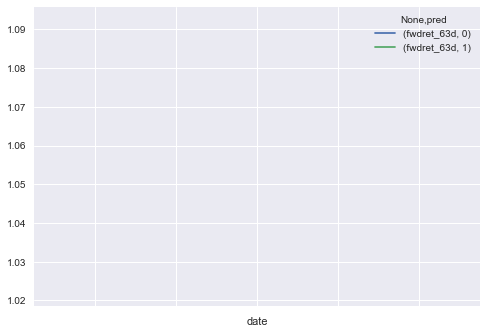

In [36]:
(test.groupby([pd.Grouper(level=0), 'pred']).mean().unstack()+1)[::63].cumprod().plot()
(test.groupby([pd.Grouper(level=0)])['fwdret_63d'].mean()+1)[::63].cumprod().plot()

**Random Forest**

In [64]:
#https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, 
                                            stop = 400, 
                                            num = 10)]
# Number of features to consider at every split
max_features = ['sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 
                                         110,
                                         num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 15, 30]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
rf_params = {'rf_clf__n_estimators': n_estimators,
             'rf_clf__max_features': max_features,
             'rf_clf__max_depth': max_depth,
             'rf_clf__min_samples_split': min_samples_split,
             'rf_clf__min_samples_leaf': min_samples_leaf,
             'rf_clf__bootstrap': bootstrap
            }

In [65]:
from sklearn.ensemble import RandomForestClassifier

#Define stetps
steps = [('scale', MinMaxScaler()),
         ('rf_clf', RandomForestClassifier(random_state=42))]

pipe = pipeline.Pipeline(steps=steps)

#Define cross-validation 
n_splits = 20 #20
tscv = TimeSeriesSplit(n_splits=n_splits, max_train_size=2000)

#Create scoring function
fscore = make_scorer(fbeta_score, beta=.5, average='macro')

#Fit data and make predictions with tscv
iterations = 100
rf_model = RandomizedSearchCV(pipe, 
                              rf_params, 
                              n_iter=iterations,
                              scoring=fscore, 
                              cv=tscv,
                              random_state=5,
                              n_jobs=-1
                             )

rf_model.fit(X_me, y_me.values.ravel())

rf_cv_score = cross_val_score(rf_model.best_estimator_, 
                              X, 
                              y.values.ravel(), 
                              cv=tscv, 
                              scoring=fscore)

In [103]:
#Import standard plotly modules
import plotly.graph_objs as go
import plotly.plotly as py

#Import Cufflinks wrapper for plotly
import cufflinks

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

#REMOVE THIS BEFORE SUBMITTING
import plotly
plotly.tools.set_credentials_file(username='joeImp', 
                                  api_key='W9WYzHG9QeYTZiM53w6E')